In [15]:
import os
import pandas as pd
import numpy as np
import json
import folium
from IPython.display import display, HTML
from ipywidgets import widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import branca.colormap as cm
from matplotlib import colors
import seaborn as sns
sns.set()

In [16]:
df_refugee = pd.read_csv("time_series.csv",low_memory=False)
display(df_refugee.size)
df_refugee['Value'] = pd.to_numeric(df_refugee['Value'], errors='coerce')
df_refugee= df_refugee[df_refugee['Value'] > 0]
df_refugee = df_refugee[df_refugee['Year']>1984]
display(df_refugee.shape)
df_refugee = df_refugee.groupby(['Year','Country / territory of asylum/residence','Origin']).sum().reset_index()
df_refugee = df_refugee.rename(columns={"Year":"year","Value":"value"})
display(df_refugee.head(1))

1492205

(161831, 5)

,year,Country / territory of asylum/residence,Origin,value
0,1985,Algeria,Chile,100.0


In [17]:
df_geo  = pd.read_csv("geo.csv",na_values ='NaN',keep_default_na =False)
display(df_geo.head(1))

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra


In [36]:
df_isos = pd.read_csv("../docs/data/iso2_to_iso3.csv", sep=',')
df_pop = pd.read_csv("../docs/data/population.csv")

df_pop = df_pop.merge(df_isos, left_on='Country Code', right_on='iso3')
df_pop = df_pop.drop(['Country Name', 'Country Code', 'iso3'], 1)
df_pop = df_pop.rename(columns={'Value':'population', 'Year':'year'})
display(df_pop.head())

,year,population,iso2
0,1960,8996351.0,AF
1,1961,9166764.0,AF
2,1962,9345868.0,AF
3,1963,9533954.0,AF
4,1964,9731361.0,AF


In [26]:

df_merge = df_refugee.merge(df_geo, left_on='Country / territory of asylum/residence', right_on='name', how='inner')
df_merge = df_merge[['year','value','Origin',"country"]]
df_merge = df_merge.rename(columns={"country" : "country_asylum"})
df_merge = df_merge.merge(df_geo, left_on='Origin', right_on='name', how='inner')

df_merge = df_merge[['year',"country","country_asylum",'value']]
df_merge = df_merge.rename(columns={"country":"country_origin"})

df_merge = df_merge[df_merge['country_asylum']!=df_merge['country_origin']]

df_merge = df_merge.sort_values("year")

display(df_merge[df_merge.country_origin=='DZ'].head())

,year,country_origin,country_asylum,value
54906,1985,DZ,IT,3.0
54907,1986,DZ,IT,1.0
54908,1987,DZ,IT,1.0
54909,1988,DZ,IT,1.0
55306,1988,DZ,GB,4.0


In [19]:
df_immigration_exit = df_merge.drop("country_asylum",1)
df_immigration_exit = df_immigration_exit.groupby(["year","country_origin"]).sum().reset_index()
df_immigration_exit= df_immigration_exit.sort_values(["country_origin","year"])
display(df_immigration_exit.head())
df_immigration_exit.to_csv("data_immigration_exit.csv", sep=',', encoding='utf-8',index = False)

,year,country_origin,value
893,1994,AD,2.0
1060,1995,AD,2.0
1232,1996,AD,3.0
1409,1997,AD,1.0
1588,1998,AD,2.0


In [20]:
df_immigration_entry = df_merge.drop("country_origin",1)
df_immigration_entry = df_immigration_entry.groupby(["year","country_asylum"]).sum().reset_index()
df_immigration_entry= df_immigration_entry.sort_values(["country_asylum","year"])
df_immigration_entry = df_immigration_entry[["country_asylum","year","value"]]
display(df_immigration_entry.head())
df_immigration_entry.to_csv("data_immigration_entry.csv", sep=',', encoding='utf-8',index = False)

,country_asylum,year,value
0,AE,1985,6350.0
619,AE,1993,427.0
751,AE,1994,474.0
882,AE,1995,404.0
1016,AE,1996,450.0


In [21]:
import math
def keepNonNan(country_origin,country_asylum):
    if (country_origin == 0):
        return country_asylum
    if (country_asylum == 0):
        return country_origin 
    return country_origin

In [22]:
df_immigration_delta = df_immigration_entry.merge(df_immigration_exit,right_on=['year','country_origin'], left_on=['year','country_asylum'], how='outer')
df_immigration_delta = df_immigration_delta.fillna(0)
df_immigration_delta['country'] = df_immigration_delta.apply(lambda x:keepNonNan(x['country_origin'],x['country_asylum']),axis = 1)

df_immigration_delta = df_immigration_delta[df_immigration_delta.country != 0]
df_immigration_delta['value'] = df_immigration_delta.value_x - df_immigration_delta.value_y

df_immigration_delta = df_immigration_delta[["year","country","value"]]
df_immigration_delta = df_immigration_delta.sort_values(["year","country"])
display(df_immigration_delta.head())

,year,country,value
0,1985,AE,6350.0
4328,1985,AF,-4654343.0
4353,1985,AL,-3067.0
4360,1985,AM,-333.0
104,1985,AO,-226502.0


In [43]:
df_immigration_props = df_immigration_delta.merge(
    df_pop,
left_on=['year', 'country'],
right_on=['year', 'iso2'],
how='left')

df_immigration_props['per_million'] = 1e6 * df_immigration_props['value'] / df_immigration_props['population']
df_immigration_props['per_million'] = df_immigration_props['per_million'].fillna(0)
df_immigration_props = df_immigration_props.drop(['value', 'iso2', 'population'], axis=1)
display(df_immigration_props[df_immigration_props.country=='SY'])
df_immigration_props.to_csv("data_population_fraction.csv", sep=',', encoding='utf-8',index = False)

,year,country,per_million
87,1985,SY,3449.363261
188,1986,SY,8.723885
289,1987,SY,-1.760431
399,1988,SY,-57.257098
517,1989,SY,-32.863031
642,1990,SY,158.844033
778,1991,SY,86.849862
921,1992,SY,131.340626
1078,1993,SY,2439.220927
1245,1994,SY,2363.133766


In [23]:
print(np.linspace(0.09,1,10, endpoint=False))

[ 0.09   0.181  0.272  0.363  0.454  0.545  0.636  0.727  0.818  0.909]


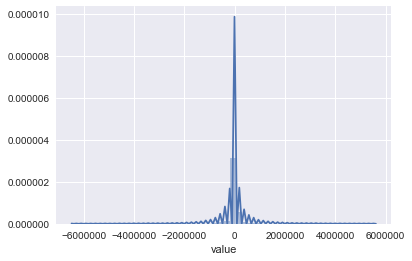

array([-8000.69566364, -1450.71453474,  -320.37279744,   -65.89568713,
          -4.88481821,    13.83158458,   181.64910404,   976.89699822,
        3215.67208069,  9600.52889319])

In [44]:
sns.distplot(df_immigration_delta.value)
plt.show()
np.set_printoptions(suppress=True)
df_immigration_props.per_million.quantile(np.linspace(0.09,1,10, endpoint=False), interpolation='nearest').values

In [25]:
df_immigration_delta.to_csv("data_immigration_delta.csv", sep=',', encoding='utf-8',index = False)